In [10]:
pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-n76c_l5j
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-n76c_l5j
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit ec50c3dfc6b9665c9eaaea7047f47cda0ba3bd54
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install torch torchvision opencv-python

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Importar bibliotecas
import os
import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.optim as optim

# Função para listar arquivos em um diretório
def listar_arquivos(diretorio):
    arquivos = os.listdir(diretorio)
    
    print(f"Conteúdo de {diretorio}:")
    print(arquivos)
    return arquivos

# Listar arquivos nos diretórios
train_images = listar_arquivos('/kaggle/input/lung-cancer-segmentation/Dataset/Treinamento/trainamento_images')
train_masks = listar_arquivos('/kaggle/input/lung-cancer-segmentation/Dataset/Treinamento/trainamento_masks')
val_images = listar_arquivos('/kaggle/input/lung-cancer-segmentation/Dataset/Validacao/val_images')
val_masks = listar_arquivos('/kaggle/input/lung-cancer-segmentation/Dataset/Validacao/val_masks')
test_images = listar_arquivos('/kaggle/input/lung-cancer-segmentation/Dataset/Teste/test_images')
test_masks = listar_arquivos('/kaggle/input/lung-cancer-segmentation/Dataset/Teste/test_masks')

Conteúdo de /kaggle/input/lung-cancer-segmentation/Dataset/Treinamento/trainamento_images:
['1231.png', '2015.png', '2300.png', '1522.png', '2064.png', '641.png', '1088.png', '173.png', '2448.png', '1746.png', '1958.png', '815.png', '1794.png', '1684.png', '1814.png', '491.png', '2276.png', '1457.png', '1924.png', '1084.png', '718.png', '709.png', '889.png', '379.png', '780.png', '248.png', '1680.png', '1675.png', '2273.png', '94.png', '480.png', '2256.png', '2021.png', '1944.png', '2518.png', '2176.png', '1343.png', '2347.png', '771.png', '2525.png', '513.png', '2009.png', '314.png', '655.png', '762.png', '726.png', '2199.png', '1630.png', '61.png', '377.png', '1961.png', '1798.png', '2324.png', '581.png', '1782.png', '222.png', '330.png', '511.png', '579.png', '278.png', '2146.png', '1863.png', '927.png', '303.png', '37.png', '231.png', '2367.png', '645.png', '2270.png', '348.png', '353.png', '621.png', '2134.png', '1726.png', '148.png', '403.png', '1590.png', '1995.png', '2121.png',

In [13]:
# Definindo a classe LungDataset
class LungDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)
        self.masks = os.listdir(masks_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

       
        image = Image.open(img_path).convert("L")  # Carrega imagem em escala de cinza
        mask = Image.open(mask_path).convert("L")   # Carrega máscara em escala de cinza

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transformação básica para as imagens e máscaras
transform = transforms.Compose([
    transforms.ToTensor(),  # Converte para tensor
])

# Criando datasets
train_dataset = LungDataset('/kaggle/input/lung-cancer-segmentation/Dataset/Treinamento/trainamento_images',
                            '/kaggle/input/lung-cancer-segmentation/Dataset/Treinamento/trainamento_masks', 
                            transform=transform)

val_dataset = LungDataset('/kaggle/input/lung-cancer-segmentation/Dataset/Validacao/val_images',
                          '/kaggle/input/lung-cancer-segmentation/Dataset/Validacao/val_masks', 
                          transform=transform)

test_dataset = LungDataset('/kaggle/input/lung-cancer-segmentation/Dataset/Teste/test_images',
                           '/kaggle/input/lung-cancer-segmentation/Dataset/Teste/test_masks', 
                           transform=transform)

# Criando DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [16]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [17]:
import torch.nn as nn
import torch.optim as optim

# Configurar o dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Configurar o otimizador e a função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [21]:
import sys
import torch
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim


# Função de Avaliação
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Loop de treinamento com barra de progresso e avaliação
num_epochs = 80  # Número de épocas
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batches = len(train_loader)
    
    for batch_idx, (images, masks) in enumerate(train_loader):
        # Verificação das máscaras binárias e presença de imagens e máscaras válidas
        if images is None or masks is None or not torch.equal(torch.unique(masks), torch.tensor([0., 1.])):
            continue  # Pular amostras inválidas

        # Enviar dados para o dispositivo
        images, masks = images.to(device), masks.to(device)
        
        # Zerar gradientes
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calcular a perda
        loss = criterion(outputs, masks)
        
        # Backward pass e otimização
        loss.backward()
        optimizer.step()
        
        # Acumular a perda
        running_loss += loss.item()
        
        # Atualizar barra de progresso
        progress = (batch_idx + 1) / total_batches
        sys.stdout.write(f'\rÉpoca {epoch+1}/{num_epochs} | Batch {batch_idx+1}/{total_batches} | Progresso: [{"=" * int(progress * 40)}{" " * (40 - int(progress * 40))}] {progress * 100:.2f}% | Perda do Batch: {loss.item():.4f}')
        sys.stdout.flush()
    
    # Perda média da época
    avg_train_loss = running_loss / len(train_loader)
    print(f'\nEpoch {epoch+1} Training Loss: {avg_train_loss:.4f}')

    # Avaliação no conjunto de validação
    avg_val_loss = evaluate_model(model, val_loader, criterion, device)
    print(f'Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}')

Época 1/80 | Batch 428/428 | Progresso: [========================================] 100.00% | Perda do Batch: 0.0039
Epoch 1 Training Loss: 0.0028
Epoch 1 Validation Loss: 0.0237
Época 2/80 | Batch 428/428 | Progresso: [========================================] 100.00% | Perda do Batch: 0.0067
Epoch 2 Training Loss: 0.0029
Epoch 2 Validation Loss: 0.0236
Época 3/80 | Batch 428/428 | Progresso: [========================================] 100.00% | Perda do Batch: 0.0080
Epoch 3 Training Loss: 0.0028
Epoch 3 Validation Loss: 0.0235
Época 4/80 | Batch 428/428 | Progresso: [========================================] 100.00% | Perda do Batch: 0.0035
Epoch 4 Training Loss: 0.0027
Epoch 4 Validation Loss: 0.0249
Época 5/80 | Batch 428/428 | Progresso: [========================================] 100.00% | Perda do Batch: 0.0025
Epoch 5 Training Loss: 0.0028
Epoch 5 Validation Loss: 0.0238
Época 6/80 | Batch 427/428 | Progresso: [======================================= ] 99.77% | Perda do Batch: 0.

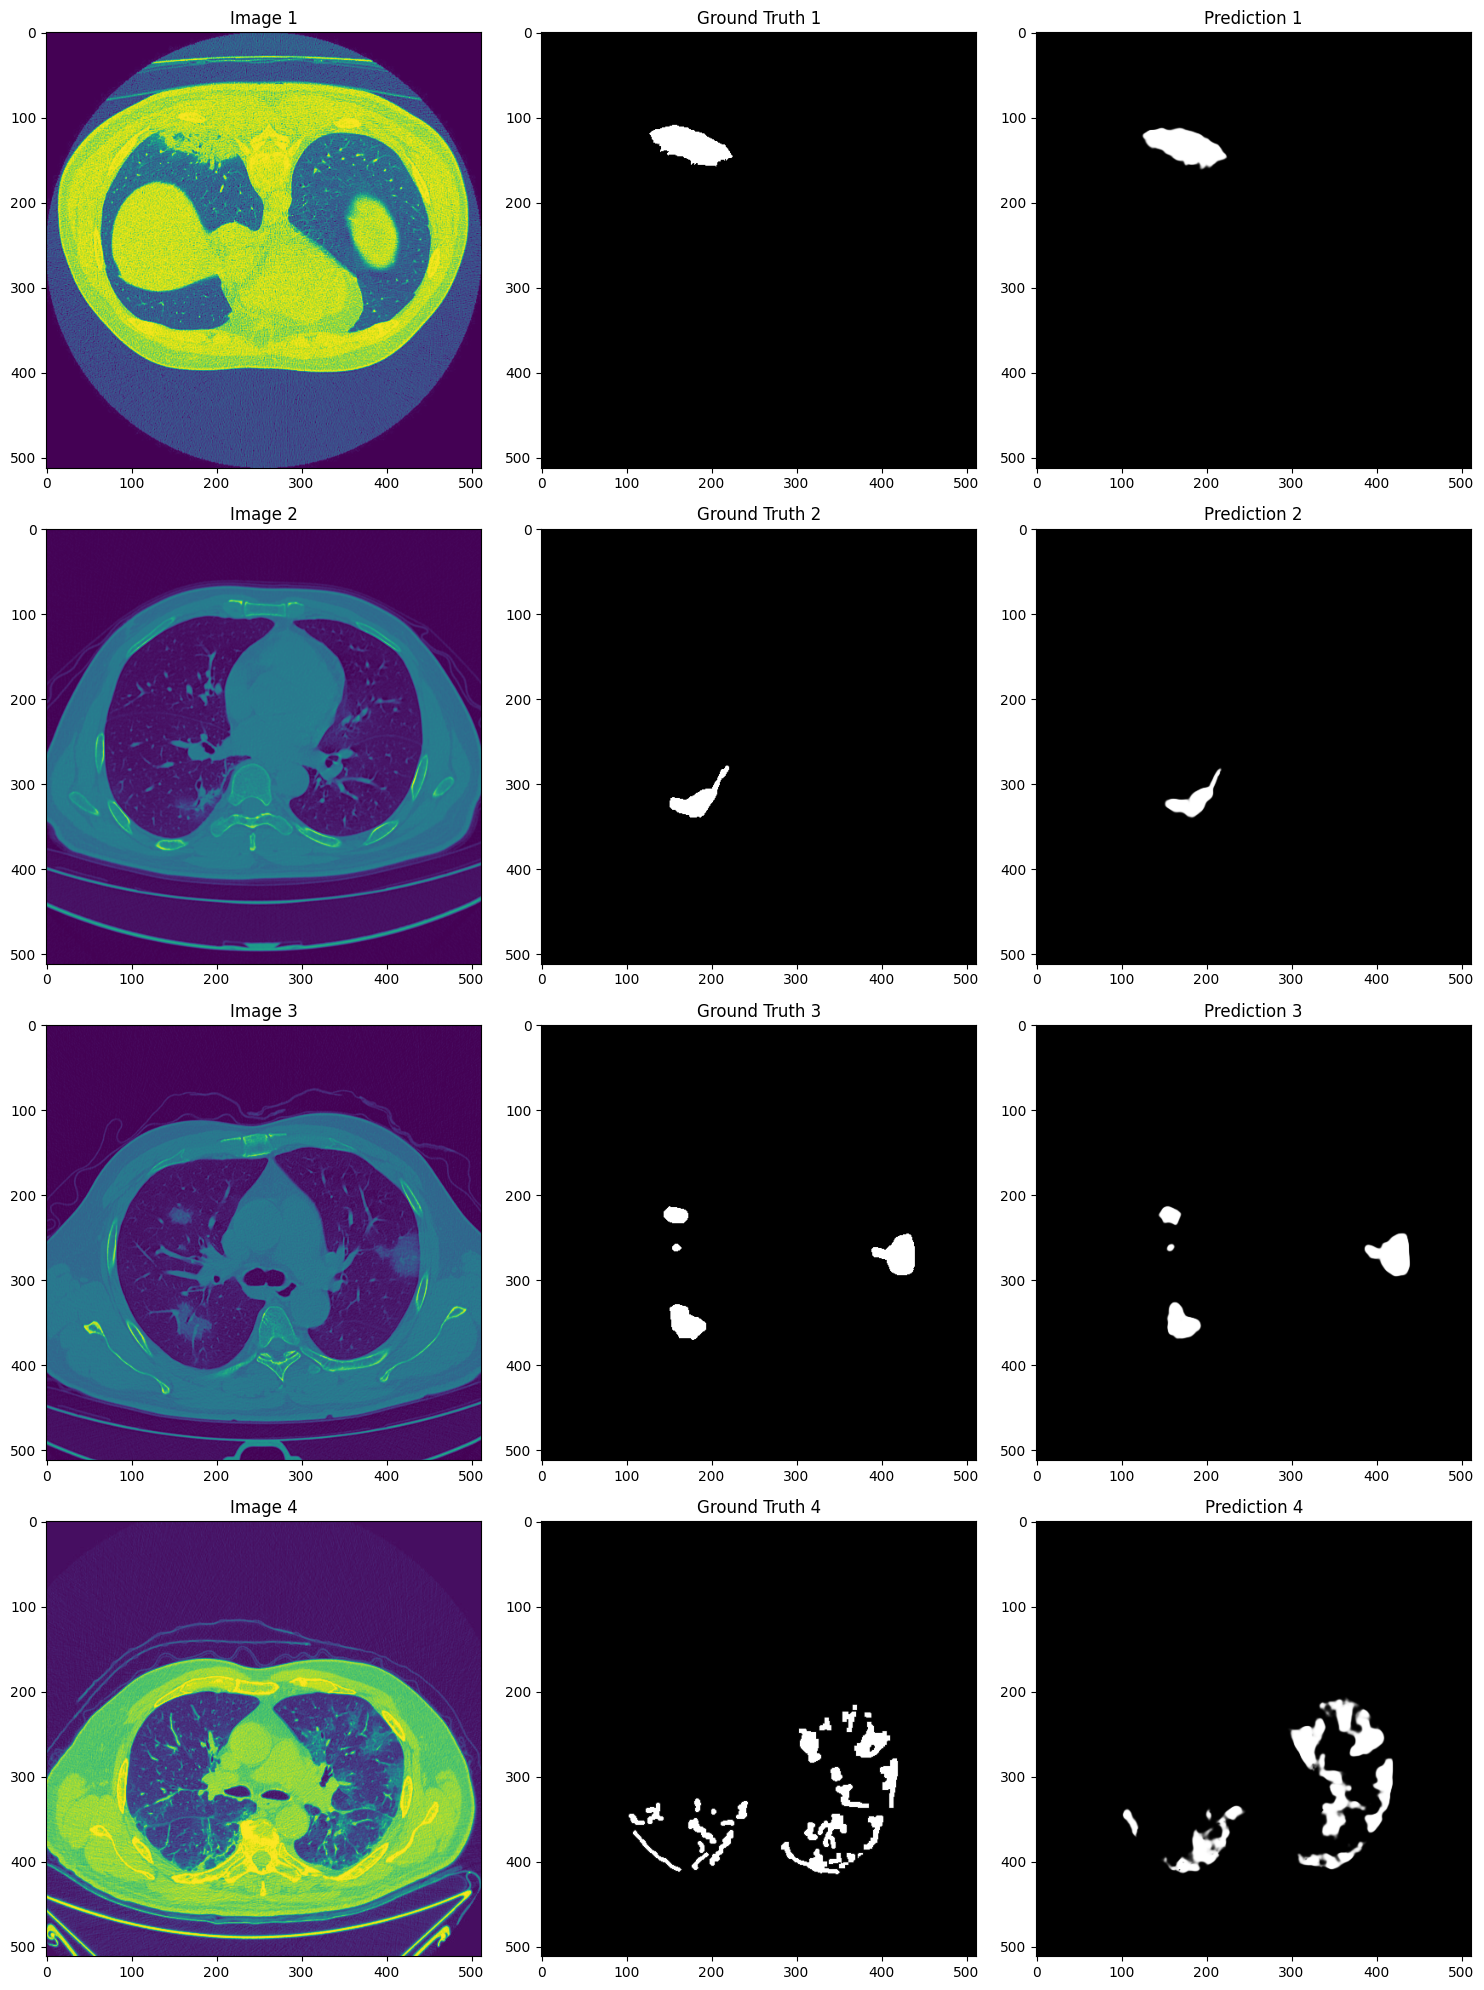

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_samples_with_continuous_predictions(images, masks, predictions):
    num_samples = len(images)  # Número de amostras a serem exibidas
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).cpu().numpy()  # Converter imagem para HWC
        mask = masks[i].squeeze().cpu().numpy()           # Remover dimensões extras da máscara
        prediction = torch.sigmoid(predictions[i]).squeeze().cpu().numpy()  # Aplicar sigmoid se necessário
        
        # Normalizar a previsão para o intervalo [0, 1]
        prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())
        
        # Exibir as imagens nas colunas
        axes[i, 0].imshow(image)  # Exibir imagem original
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 1].imshow(mask, cmap='gray')  # Exibir máscara
        axes[i, 1].set_title(f'Ground Truth {i+1}')
        axes[i, 2].imshow(prediction, cmap='gray')  # Exibir previsão com tons de cinza
        axes[i, 2].set_title(f'Prediction {i+1}')
    
    plt.tight_layout()
    plt.show()

# Testar a visualização com o código ajustado
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        visualize_samples_with_continuous_predictions(images.cpu(), masks.cpu(), outputs.cpu())
        break  # Visualize apenas o primeiro lote

In [ ]:
import torch

def calculate_dice(preds, targets, threshold=0.5):
    """
    Calcula o DICE para segmentação binária.
    Args:
        preds (torch.Tensor): Predições do modelo, tensor de logits com shape [N, 1, H, W].
        targets (torch.Tensor): Máscaras reais, tensor com shape [N, 1, H, W].
        threshold (float): Limite para converter logits em valores binários.
    Returns:
        float: DICE médio para o batch.
    """
    # Aplicar sigmoid para converter logits em probabilidades
    preds = torch.sigmoid(preds)
    # Aplicar limiar para obter valores binários
    preds = (preds > threshold).float()
    
    intersection = (preds * targets).sum(dim=(2, 3))
    dice = (2 * intersection) / (preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)))
    
    # Evita divisão por zero e calcula a média
    dice_score = dice.mean().item()
    return dice_score

def evaluate_model_with_metrics(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
            
            # Cálculo de IoU e DICE para o batch
            batch_dice = calculate_dice(outputs, masks)
            
            total_dice += batch_dice
    
    # Média das métricas no conjunto de validação
    avg_val_loss = val_loss / len(val_loader)
    avg_dice = total_dice / len(val_loader)
    
    print(f'Validation Loss: {avg_val_loss:.4f}, DICE: {avg_dice:.4f}')


evaluate_model_with_metrics(model, val_loader, criterion, device)

Validation Loss: 0.0372, IoU: 0.6491, DICE: 0.7589
